In [48]:
import os 
import glob
import pandas as pd 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load in the Data

In [49]:
plt.rc('font', size=14)

In [2]:
#  v1 dfs
## get filepaths
cache_dir = '../scraping/scrapy-cloud/output_dir/'
files = glob.glob(os.path.join(cache_dir, '*'))
article_files = list(filter(lambda x: 'newssniffer-index' not in x, files))
csvs = list(filter(lambda x: '.csv' in x, article_files))
jsons = list(filter(lambda x: '.json' in x, article_files))

## read in CSVs and JSONs
article_dfs = list(map(lambda x: pd.read_csv(x, index_col=0), tqdm(csvs)))
article_jsons = []
for x in tqdm(jsons):
    try: 
        j = pd.read_json(x, orient='records', lines=True)
    except:
        j = pd.read_json(x, orient='records')
    article_jsons.append(j)

article_df = pd.concat([
    pd.concat(article_dfs).rename(columns={'url':'article_url', 'file_id': 'article_id'}),
    pd.concat(article_jsons).drop('request_url', axis=1)
])

article_df = article_df.drop_duplicates(['version', 'article_id']).reset_index(drop=True)

In [268]:
article_page_files = glob.glob('../scraping/scrapy-cloud/output_dir/search_output/output-*-8.json')
article_page_files = sorted(article_page_files, key=lambda x: int(re.search('output-(\d+)-8.json', x)[1]))
large_article_files = glob.glob('../scraping/scrapy-cloud/output_dir/article-ou*')

In [275]:
article_page_df = pd.read_json(article_page_files[0])

In [277]:
article_page_df.head(2)

,version_url,version,time_created,time_delta,title,article_url,article_id,source
0,https://www.newssniffer.co.uk/articles/35/vers...,0,"August 29, 2006 01:35",,Annan asks Israel to end blockade,http://news.bbc.co.uk/go/rss/-/1/hi/world/midd...,35,bbc
1,https://www.newssniffer.co.uk/articles/36/vers...,0,"August 29, 2006 01:35",,Dozens die in fresh Iraq violence,http://news.bbc.co.uk/go/rss/-/1/hi/world/midd...,36,bbc


In [276]:
large_article_df = pd.read_json(large_article_files[0])

In [278]:
large_article_df.head(2)

,url,html
0,https://www.newssniffer.co.uk/articles/688245/...,"<p><a href=""http://www.nytimes.com/2013/09/28/..."
1,https://www.newssniffer.co.uk/articles/688245/...,"<p><a href=""http://www.nytimes.com/2013/09/28/..."


# What time period do we have?

In [ ]:
article_df['time'] = (
    article_df['time']
          .str.split('(')
          .str.get(0)
          .str.strip()
          .pipe(lambda s: pd.to_datetime(s))
)

Text(0.5, 0, 'Published time')

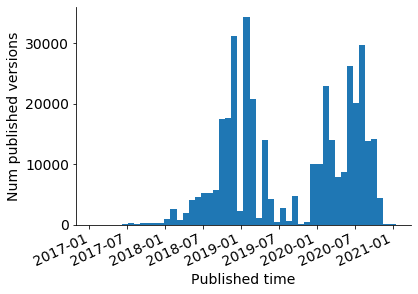

In [59]:
ax = article_df['time'].hist(bins=50)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=25, horizontalalignment='right')
plt.ylabel('Num published versions')
plt.xlabel('Published time')

In [ ]:
article_df['version'] = article_df['version'].str.split().str.get(1).astype(int)

In [77]:
article_df['source'].value_counts()

guardian    153846
nytimes     131998
bbc          55982
rtcom        12937
washpo       12136
Name: source, dtype: int64

In [78]:
article_df.drop_duplicates('article_id')['source'].value_counts()

guardian    37253
nytimes     19140
bbc         14242
rtcom        4921
washpo       3135
Name: source, dtype: int64

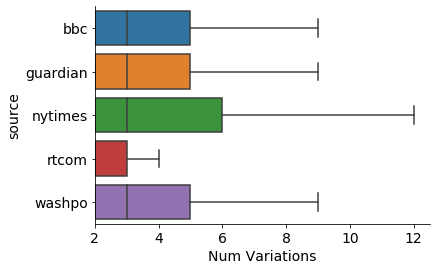

In [91]:
ax = (article_df
 .groupby(['source', 'article_id'])['version'].aggregate(len)
 .reset_index()
 .pipe(lambda df: 
      sns.boxplot(data=df, y='source', x='version', showfliers=False)
      )
)
ax.set_xlim(2, 12.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Num Variations');

# Try new Diff Scheme
## Sentence diffs -> words per sentence diffs -> letters per word diffs

In [116]:
from difflib import ndiff
import spacy

In [ ]:
unique_article_ids = article_df['article_id'].drop_duplicates()
indexed_article_df = article_df.set_index('article_id')
for a_id in unique_article_ids:
    indexed_article_df.loc[a_id]

In [137]:
nlp = spacy.load("en_core_web_lg", disable=["tagger", "ner"]) # just the parser

In [123]:
a1, a2 = indexed_article_df.loc[a_id]['text'].iloc[[0, 1]]

In [189]:
to_filter = [
    'Share on WhatsApp',
    'Share on Messenger',
    'Reuse this content',
    'Share on LinkedIn',
    'Share on Pinterest' ,
    'Share on Google+',
    'Listen /',
    '– Politics Weekly',
    'Sorry your browser does not support audio',
    'https://flex.acast.com',
    '|',
    'Share on Facebook',
    'Share on Twitter',
    'Share via Email',
    'Sign up to receive',
    'This article is part of a series',
    'Follow Guardian',
    'Twitter, Facebook and Instagram',
    'UK news news',
    'Click here to upload it',
    'Do you have a photo',
    'Listen /',
    'Email View',
    'Read more Guardian',
    'This series is',
    'Readers can recommend ',
    'UK news news',
    'Join the debate',
    'guardian.letters@theguardian.com',
    'More information',
    'Close',
    'All our journalism is independent',
    'is delivered to thousands of inboxes every weekday',
    'with today’s essential stories',
    'Newsflash:',
    'You can read terms of service here',
    'Guardian rating:',
    'By clicking on an affiliate link',
    'morning briefing news',
    'Analysis:',
    'Good morning, and welcome to our rolling coverage',
    'South and Central Asia news',
    'f you have a direct question',
    'sign up to the',
    'You can read terms of service here.',
    'If you want to attract my attention quickly, it is probably better to use Twitter.',
    'UK news',
]

to_filter = list(map(lambda x: x.lower(), to_filter))
def split_sents(a, perform_filter=True):
    if perform_filter:
        a = filter_lines(a)
    a = a.replace('</p>', ' ').replace('<p>', ' ')
    a = ' '.join(a.split())
    doc = nlp(a)
    return list(map(lambda x: x.text, doc.sents))

def filter_lines(a):
    pars = a.split('</p>')
    output = []
    for p in pars:
        if not any(map(lambda x: x in p.lower(), to_filter)):
            output.append(p)
    return '</p>'.join(output)

## Filter out common phrases

In [186]:
from collections import defaultdict
from tqdm.auto import tqdm

In [190]:
sentence_counts = defaultdict(int)
guardian_articles = article_df.loc[lambda df: df['source'] == 'guardian']['text'].sample(2000)
for idx, a in tqdm(enumerate(guardian_articles), total=len(guardian_articles)):
    sents = split_sents(a, perform_filter=True)
    for s in sents:
        if idx < 500:
            sentence_counts[s] += 1
        if idx > 500:
            if s in sentence_counts:
                sentence_counts[s] += 1

  0%|          | 0/2000 [00:00<?, ?it/s]

# Sentence-Level Diff Styling

In [159]:
a1_sents = split_sents(a1)
a2_sents = split_sents(a2)

In [224]:
vars_old = []
vars_new = []


diffs = list(difflib.ndiff(a1_sents, a2_sents))
in_question = False
for idx, sent in enumerate(diffs):
    label, text = sent[0], sent[2:]
    if label == '?':
        continue
    
    elif label == '-':
        vars_old.append({
            'text': text,
            'tag': '-'
        })
        if (idx < len(diffs)):
            if diffs[idx + 1][0] == '?':
                in_question = True
            else:
                vars_new.append({
                    'text': '',
                    'tag': ' '                    
                })
    
    elif label == '+':
        vars_new.append({
            'text': text,
            'tag': '+'
        })
        if in_question:
            in_question = False
        else:
            vars_old.append({
                'text':'',
                'tag': ' '
            })
    
    else:
        vars_old.append({
            'text': text,
            'tag': ' '
        })
        vars_new.append({
            'text': text,
            'tag': ' '
        })

In [240]:
html = [
    '<table>',
    '<tr><th>Old Version</th><th>New Version</th></tr>'
]

for s_old, s_new in zip(vars_old, vars_new):
    row = '<tr>'
    if s_old['tag'] == '-':
        row += '<td style="background-color:rgba(255,0,0,0.3)">' + s_old['text'] + '</td>'
    else:
        row += '<td>' + s_old['text'] + '</td>'
    if s_new['tag'] == '+':
        row += '<td style="background-color:rgba(0,255,0,0.3)">' + s_new['text'] + '</td>'
    else:
        row += '<td>' + s_new['text'] + '</td>'
    row += '</tr>'
    html.append(row)
html.append('</table>')

In [241]:
from IPython.display import display, HTML

In [242]:
display(HTML('\n'.join(html)))

Old Version,New Version
The Windrush scandal exposed by the Guardian has led to significant changes in the immigration system.,The Windrush scandal exposed by the Guardian has led to significant changes in the immigration system.
"Members of the Windrush generation, who arrived in the UK from 1948 onwards, as well as their children, have been wrongly targeted by the government’s “hostile environment” policies designed to deter illegal immigrants.","Members of the Windrush generation, who arrived in the UK from 1948 onwards, as well as their children, have been wrongly targeted by the government’s “hostile environment” policies designed to deter illegal immigrants."
"Some of those caught up have been forced out of work as a result, in some cases for years, and left unable to claim welfare support, while others have been wrongfully detained or even deported.","Some of those caught up have been forced out of work as a result, in some cases for years, and left unable to claim welfare support, while others have been wrongfully detained or even deported."
Here we take a look at some of the key changes and support that have been offered.,Here we take a look at some of the key changes and support that have been offered.
Citizenship The Windrush taskforce was set up on 18 April after the Guardian’s initial reporting.,Citizenship The Windrush taskforce was set up on 18 April after the Guardian’s initial reporting.
"As of Thursday, a helpline had received more than 13,000 calls with more than 5,000 identified as potential Windrush cases.","As of Thursday, a helpline had received more than 13,000 calls with more than 5,000 identified as potential Windrush cases."
More than 850 people have received crucial documentation following appointments with the team.,More than 850 people have received crucial documentation following appointments with the team.
This will help them confirm their right to be in the UK.,This will help them confirm their right to be in the UK.
Compensation,Compensation
The government committed to launching a compensation scheme for the potentially thousands of people caught up in the scandal.,The government committed to launching a compensation scheme for the potentially thousands of people caught up in the scandal.
